In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim 
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
words = open("input.txt", "r").read().splitlines()
words[:1]

In [ ]:
# vocabulary 

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
iots = {i:s for s,i in stoi.items()}

In [ ]:
#build dataset

block_size = 3 # context length
X, Y =[] ,[]
for w in words:
    context = [0]*block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] 
X = torch.tensor(X)
Y = torch.tensor(Y)


In [100]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
C = torch.rand((27, 2))

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).shape

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C 

# 1 27 X 27 2 --> 1x2
# the above 1 is added when broadcasting 

In [ ]:
C[5]

In [ ]:
C[X].shape

In [ ]:
emd = C[X]
emd.shape

In [ ]:
w1 = torch.randn((6, 100))
w1

In [ ]:
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emd.view(emd.shape[0], 6) @ w1 + b1)
h

In [ ]:
h.shape

In [ ]:
# second layer

w2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [ ]:
logits = h @ w2 + b2
logits

In [ ]:
# softmax

counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

In [153]:
# let sum it up

g = torch.Generator().manual_seed(1219)

C = torch.randn(
    (27, 10), generator=g
)  # embedding table that has 10d vector for all 27 unique characters
w1 = torch.randn((30, 200), generator=g) # first layer weights. we have 3 inputs each input as 2d vector and connecting to 100 neurons
b1 = torch.randn(200, generator=g) # bias for 100 terms

w2 = torch.randn((200, 27), generator=g) # final output layer has 27 neurons
b2 = torch.randn(27, generator=g)

parameters = [C, w1, b1, w2, b2]

In [154]:
sum(p.nelement() for p in parameters)

11897

In [155]:
for p in parameters:
    p.requires_grad = True

In [60]:
for _ in range(50):
    # forward pass
    emd = C[X]
    h = torch.tanh(emd.view(-1, 6) @ w1 +b1) 
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #update params 
    for p in parameters:
        p.data += -0.1 * p.grad # lr = 0.01

# no mini batch concept is used so optimization is lower
# in the next we will use mini batch to increase the speed

4.357812404632568
4.320883750915527
4.285501956939697
4.25156307220459
4.218959808349609
4.187586784362793
4.157344341278076
4.128137111663818
4.099877834320068
4.072488307952881
4.045897006988525
4.02004337310791
3.994873523712158
3.970343828201294
3.9464144706726074
3.923055648803711
3.9002397060394287
3.8779449462890625
3.8561530113220215
3.8348476886749268
3.8140158653259277
3.793647050857544
3.773728847503662
3.75425386428833
3.7352135181427
3.716597557067871
3.698399782180786
3.6806116104125977
3.6632254123687744
3.6462326049804688
3.6296260356903076
3.613396406173706
3.597536563873291
3.5820376873016357
3.566890239715576
3.5520875453948975
3.5376193523406982
3.523477077484131
3.509652853012085
3.496137857437134
3.4829235076904297
3.470001459121704
3.4573633670806885
3.4450020790100098
3.432908058166504
3.421074867248535
3.409494400024414
3.3981595039367676
3.3870630264282227
3.3761978149414062


In [75]:
for _ in range(50):

    # mini batch
    ix = torch.randint(0, X.shape[0], (32,))  # batch size is 32

    # forward pass
    emd = C[X[ix]]
    h = torch.tanh(emd.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update params
    for p in parameters:
        p.data += -0.1 * p.grad  # lr = 0.01

18.28337860107422
17.214359283447266
15.086169242858887
17.050569534301758
11.695022583007812
12.706181526184082
12.60617733001709
10.292503356933594
9.966450691223145
11.272492408752441
10.136370658874512
9.30547046661377
9.305124282836914
11.402600288391113
9.264123916625977
8.007962226867676
9.965206146240234
8.776593208312988
8.516800880432129
7.876096248626709
7.814176559448242
6.321028232574463
6.332528591156006
6.900425910949707
6.719913959503174
6.640930652618408
5.032785892486572
5.749258995056152
5.843288421630859
5.0417399406433105
5.506636619567871
5.321962356567383
6.710090637207031
6.624609470367432
5.962802410125732
5.611135005950928
4.841049671173096
4.345086097717285
5.36767053604126
5.324273109436035
5.992996692657471
5.823202610015869
4.524528980255127
5.373772621154785
4.6309638023376465
4.706752777099609
4.079817771911621
5.968479633331299
4.954121112823486
4.919981956481934


In [76]:
# finding the optimal lr

lre = torch.linspace(-3, 0 , 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [85]:
lossi = []
lri = []

for i in range(1000):
    # mini batch
    ix = torch.randint(0, X.shape[0], (32,))  # batch size is 32
    # forward pass
    emd = C[X[ix]]
    h = torch.tanh(emd.view(-1, 6) @ w1 +b1) 
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # choose the lr
    lr = lrs[i]
    #update params 
    for p in parameters:
        p.data += -lr * p.grad
    
    lri.append(lre[i])
    lossi.append(loss.item())



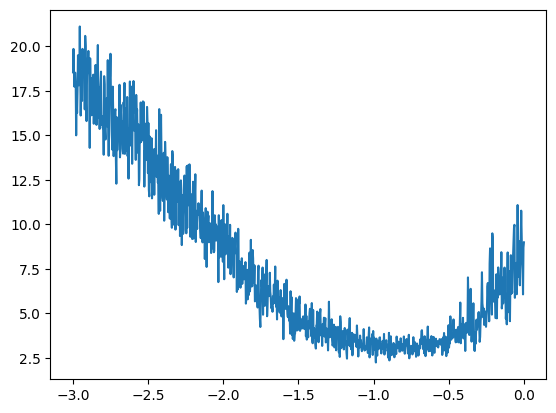

In [86]:
plt.plot(lri, lossi)

In [156]:
lri = []
stepi = []
lossi = []

In [157]:
# optimal lr is 0.1


for i in range(200000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))  # batch size is 32
    # forward pass
    emd = C[Xtr[ix]]
    h = torch.tanh(emd.view(-1, 30) @ w1 +b1) 
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # choose the lr
    lr = 0.1 if i < 100000 else 0.01
    #update params 
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item()) 


1.8309409618377686


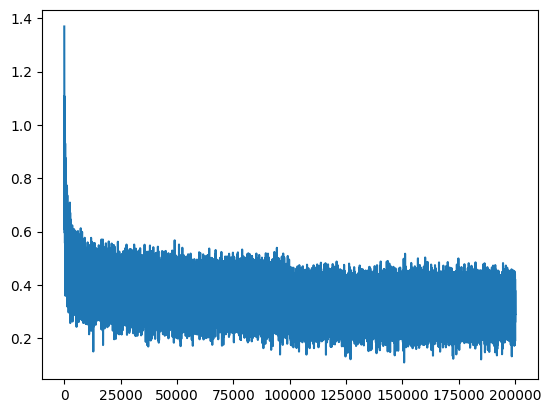

In [158]:
plt.plot(stepi, lossi)

In [159]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1219, grad_fn=<NllLossBackward0>)

In [160]:
# dev loss 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 100)
logits = h @ w2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1681, grad_fn=<NllLossBackward0>)

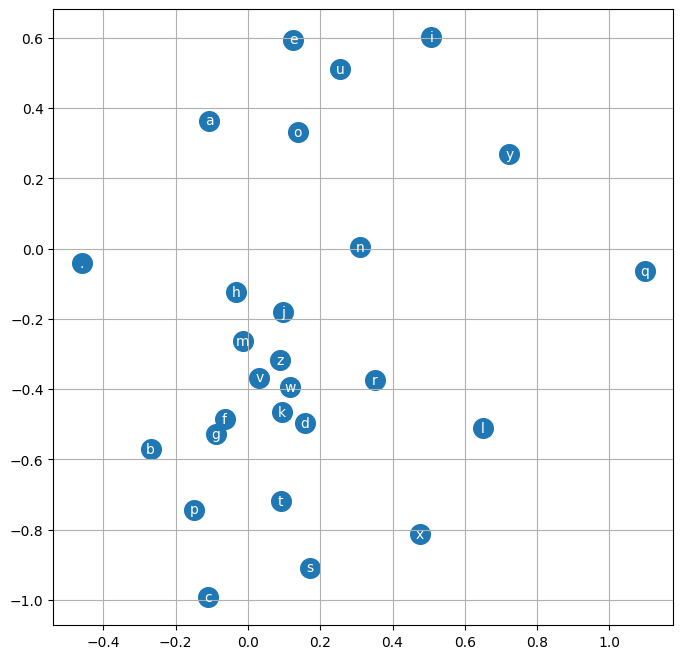

In [143]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters (for 2d vectors alone)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), iots[i], ha="center", va="center", color='white')
plt.grid('minor')

In [161]:
# sample names from the model

# sample from the model
g = torch.Generator().manual_seed(1219 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(iots[i] for i in out))

maricief.
eam.
dan.
bren.
ala.
ajmalailakan.
arbi.
rayte.
rayel.
kee.
muct.
kavonna.
rhy.
aad.
nianayelon.
autan.
emar.
arag.
hadyza.
que.
